# Performing a simple Load-Pull Simulation using MultiADSweep

Preparations: Download the example workspace, open the LoadPullPython schematic and create a netlist.

In [3]:
import keysight.pwdatatools as pwdt
import pandas as pd
import numpy as np
import skrf
import matplotlib.pyplot as plt


from MultiADSweep.evaluation import get_block_containing_variable, extract_variable_as_dataframe, block_to_dataframe
import MultiADSweep.calc as mc

## Generating Simulation Points for an Example Load-Pull Simulation

This section demonstrates the generation of simulation points for a Load-Pull simulation using the `MultiADSweep` library. The process is crucial for defining the parameter space over which the simulation will sweep.

### Key Concepts:
- **Sweeping Variables**: Variables intended for sweeping should be predefined in the ADS Schematic with arbitrary values. These variables are then automatically added as independent variables to the output dataset.
- **Variable Ordering**: The addition of variables to the dataset follows a specific order, mirroring the nested parameter sweep approach in ADS. In this example, `GL_re` represents the inner sweep, and `GL_im` is the outer sweep.
- **Flexibility in Variables**: The framework allows for an unlimited number of sweeping variables, providing extensive flexibility in simulation setup.

### Complex Point Generation:
The `generate_complex_points` function from `MultiADSweep.utilities` is used to generate complex sampling points. This function supports various patterns, including circular and rectangular layouts, to suit different simulation requirements.


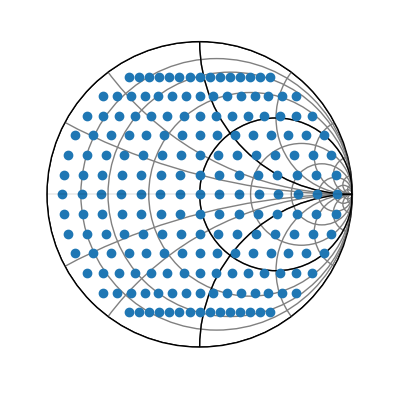

In [4]:
from MultiADSweep.utilities import generate_complex_points
import pandas as pd
import numpy as np

# Complex Point Generation:
# Creating a complex NumPy array to represent the simulation points.
gl_cpx = generate_complex_points(mode="circular_scaled",  num_points_per_direction = 15, radius=0.9)

# Decomposition of Points:
# Converting the complex array into a list of tuples.
vals = [(g.real, g.imag) for g in gl_cpx]

# MultiIndex Creation
# This MultiIndex is crucial for managing simulation variables in the `MultiADSweep` framework
names=["GL_re", "GL_im"]
vars = pd.MultiIndex.from_tuples(vals, names = names)

#Plotting the datapoints
%matplotlib inline
f, ax = plt.subplots()
skrf.plotting.smith(ax=ax, smithR = 1, chart_type = "z", draw_labels = False, border = False, ref_imm = 1.0, draw_vswr = None)
plt.scatter(gl_cpx.real, gl_cpx.imag)
plt.show()

## Initializing the Simulation Manager

Before initializing the `SimulationManager`, ensure the necessary preparations are completed. This includes downloading the example workspace, opening the `LoadPullPython` schematic in ADS, and creating a netlist file. The `SimulationManager` will simulate the schematic for which the netlist has been created in the ADS workspace.

The `SimulationManager` is then initialized with various parameters that define the simulation environment and behavior. Here's a breakdown of the parameters used in the initialization:

- `vars`: A Pandas MultiIndex representing the points for the new independent variables.
- `sim_name`: A freely chosen name for the simulation.
- `workspace_dir`: The directory path where the ADS workspace is located. This should be the path to the workspace containing the `LoadPullPython` schematic.
- `ads_install_dir`: The installation directory of ADS. This is required for the Simulation Manager to locate and use ADS for simulations.
- `ads_startup_cmd`: A command or a series of commands needed to set up the environment for ADS. This might include loading modules or setting environment variables.
- `max_workers`: The maximum number of parallel workers for running simulations. Ensure to have a sufficient license count available

In [5]:
from MultiADSweep.simulation import SimulationManager

manager = SimulationManager(vars =  vars,
                            sim_name="simple_lp_demo",
                            workspace_dir = "/home/users/loose/Schreibtisch/mas_demo_wrk",
                            ads_install_dir = "/opt/keysight/ADS2023_Update2",
                            ads_startup_cmd = "module load ads/2023.02",
                            max_workers=40)

Sucessfully found Netlist for Cell "LoadPullPython" at "/home/users/loose/Schreibtisch/mas_demo_wrk"


## Running the Simulation

Once the `SimulationManager` is properly initialized, the simulation can be started using the `run` method. This method will execute the simulations for all the defined points in the `vars` MultiIndex, using the parameters and environment set up during initialization.


In [6]:
manager.run()

Starting process pool. 195 Simulations, Maximum 40 Workers


100%|██████████| 195/195 [00:29<00:00,  6.66it/s]


Cumulated CPU Time: 2209.3s (36min, 49.3s)
Read 195/195 Files sucessfully 
Simulation Errors:
----------------------------------------
No errors occurred.


Simulation Warnings:
----------------------------------------
Warning detected by hpeesofsim in topology check during circuit set up.
195 occurrences (All Simulations)


Logs written to /home/users/loose/Schreibtisch/mas_demo_mas/log/simple_lp_demo.log.json
Processing Simulation Data
Done


## Retrieving Simulation Results

After the simulation process completes, the results can be accessed directly from the `SimulationManager` using the `get_results` method:
This will return a `pwdt.Group` object. Please see the [pwdt documentation](https://edadocs.software.keysight.com/pwdt0x5x0) for further information.



In [7]:
ds = manager.get_results()

## Writing Output Files for ADS Compatibility

To facilitate the analysis of simulation results within ADS (Advanced Design System), the `SimulationManager` can export the data in a format that is directly readable by ADS. You can use the `LoadPullDisplay` data display, which is included in the example ADS workspace, to view the results in ADS.

A key advantage of using the MultiADSweep Simulation tool is its ability to always produce a regular dataset. This means that the dimensions of the independent variables are consistent across all levels. In cases where simulations do not converge, these values are filled with NaN (Not a Number). This approach contrasts with ADS's handling of parameter sweeps, where a single non-converging simulation can render the entire results unusable. 

However, it's important to note that exporting large datasets can be time-consuming. Therefore, it's recommended to be mindful of the dataset size when using this feature.


In [8]:
manager.write_output_files(dst_type="ads")

Output written to /home/users/loose/Schreibtisch/mas_demo_mas/data/simple_lp_demo.ds


## Reading and Writing Output Files in the Efficient HDF5 Format

For efficient handling of simulation data, the hdf5 format is highly recommended. This format, supported by the `pwdt` (Keysight PathWave Data Tools) library, offers a much faster read and write performance compared to the traditional `ds` format. 

When using the hdf5 format, you can quickly read back the simulation data with the same structure and content as provided by `manager.get_results()`. This efficiency makes hdf5 the preferred choice, especially when immediate analysis or manipulation of the simulation results is not required.

Additionally, if you need to convert the file format at a later stage, the Keysight pwdt library provides convenient tools for this purpose. This flexibility allows you to focus on your simulation tasks without worrying about data format constraints.


In [9]:
# Writing output files in hdf5 format
manager.write_output_files(dst_type="pwdt")

Output written to /home/users/loose/Schreibtisch/mas_demo_mas/data/simple_lp_demo.pwdt


In [ ]:
# Reading the hdf5 file back into a pwdt group
ds = pwdt.read_file("/home/users/loose/Schreibtisch/mas_demo_mas/data/simple_lp_demo.pwdt")

## Reading Measurement Equation Results into Variables

In the simulation dataset, all dependent variables are organized into separate blocks. For detailed information on how these blocks are structured and managed, refer to the [pwdt documentation](https://edadocs.software.keysight.com/pwdt0x5x0).

To facilitate the extraction of specific dependent variables from these blocks, the `MultiADSweep` library provides a convenient function named `extract_variable_as_dataframe`. This function allows you to easily retrieve a single dependent variable and format it as a DataFrame. Additionally, the `unstack` option can be used to transform selected dependent variables into DataFrame columns, enhancing the readability and accessibility of the data.

Here's an example of how to use `extract_variable_as_dataframe` to extract and process various power-related variables from the simulation dataset:


In [11]:
from MultiADSweep.evaluation import extract_variable_as_dataframe

PAE = extract_variable_as_dataframe(ds, "PAE", unstack = ["GL_im", "GL_re"])
Pout_W = extract_variable_as_dataframe(ds, "Pout_W", unstack = ["GL_im", "GL_re"])
Pin_W = extract_variable_as_dataframe(ds, "Pin_W", unstack = ["GL_im", "GL_re"])
Pout_dBm = mc.w2dBm(Pout_W)
Pin_dBm = mc.w2dBm(Pin_W)


## Calculating Key Results Directly in Python

Using Python for post-processing simulation data offers significant advantages. Not only does it allow access to sophisticated numerical and scientific computing tools available in libraries like NumPy and SciPy, but it also helps in saving space. By performing calculations directly in Python, you can avoid storing large amounts of intermediate data that would typically be generated by the simulation tool itself.



In [21]:
# Extracting the first block of data, which contains the Harmonic Balance (HB) Simulation results
df = block_to_dataframe(ds.members[0])

# Displaying the names of dependent variables in the dataset
print(df.columns)

# Displaying the names of independent variables used in the sweep
print(df.index.names)

Index(['V_L', 'Main.V_fwd', 'Main.V_rev', 'Main.V_G', 'Main.V_D', 'Main.V_dd',
       'Main.T1.Vfp', 'Main.T1.Vdi', 'Main.T1.Vsi', 'Main.T1.Vgi',
       'Main.T1.Tj', 'Main.T1.Iinternal', 'Main.drain_supply.i',
       'Main.gate_supply.i', 'Main.I_Vdd.i', 'Main.I_Vg.i', 'Main.I_D.i',
       'Main.I_G.i', 'I_L.i', 'Mix[1]'],
      dtype='object')
['GL_im', 'GL_re', 'v_swp', 'freq']


In [23]:
# Displaying a DataFrame in a Jupyter Notebook provides a formatted view
df

V_L  \
GL_im     GL_re     v_swp freq                               
-0.771429 -0.463571 0.01  0.000000e+00  0.000000+0.000000j   
                          3.600000e+09  0.021959+0.075636j   
                          7.200000e+09  0.000000+0.000000j   
                          1.080000e+10  0.000000+0.000000j   
                          1.440000e+10  0.000000+0.000000j   
...                                                    ...   
 0.771429  0.463571 1.00  1.080000e+10  0.000000+0.000000j   
                          1.440000e+10  0.000000+0.000000j   
                          1.800000e+10  0.000000+0.000000j   
                          2.160000e+10  0.000000+0.000000j   
                          2.520000e+10  0.000000+0.000000j   

                                                Main.V_fwd  \
GL_im     GL_re     v_swp freq                               
-0.771429 -0.463571 0.01  0.000000e+00  0.000000+0.000000j   
                          3.600000e+09 -0.000001+0.000018j   
                          7.200000e+09  0.000000+0.000000j   
                          1.080000e+10  0.000000+0.000000j   
                          1.440000e+10  0.000000+0.000000j   
...                                                    ...   
 0.771429  0.463571 1.00  1.080000e+10  0.000000+0.000000j   
                          1.440000e+10  0.000000+0.000000j   
                          1.800000e+10  0.000000+0.000000j   
                          2.160000e+10  0.000000+0.000000j   
                          2.520000e+10  0.000000+0.000000j   

                                                Main.V_rev  \
GL_im     GL_re     v_swp freq                               
-0.771429 -0.463571 0.01  0.000000e+00  0.000000+0.000000j   
                          3.600000e+09 -0.000002+0.000001j   
                          7.200000e+09  0.000000+0.000000j   
                          1.080000e+10  0.000000+0.000000j   
                          1.440000e+10  0.000000+0.000000j   
...                                                    ...   
 0.771429  0.463571 1.00  1.080000e+10  0.000000+0.000000j   
                          1.440000e+10  0.000000+0.000000j   
                          1.800000e+10  0.000000+0.000000j   
                          2.160000e+10  0.000000+0.000000j   
                          2.520000e+10  0.000000+0.000000j   

                                                          Main.V_G  \
GL_im     GL_re     v_swp freq                                       
-0.771429 -0.463571 0.01  0.000000e+00 -2.240000e+00+0.000000e+00j   
                          3.600000e+09  4.931159e-03-3.572968e-02j   
                          7.200000e+09 -3.933623e-05+7.513500e-05j   
                          1.080000e+10 -7.140586e-07+2.138757e-07j   
                          1.440000e+10  8.241325e-09-2.259564e-08j   
...                                                            ...   
 0.771429  0.463571 1.00  1.080000e+10 -3.704994e-02+3.041489e-02j   
                          1.440000e+10  2.804143e-02-3.843361e-02j   
                          1.800000e+10 -3.713726e-02+4.671473e-02j   
                          2.160000e+10  3.458601e-02-3.374938e-02j   
                          2.520000e+10  1.098368e-02+5.969167e-02j   

                                                          Main.V_D  Main.V_dd  \
GL_im     GL_re     v_swp freq                                                  
-0.771429 -0.463571 0.01  0.000000e+00  2.799986e+01+0.000000e+00j  28.0+0.0j   
                          3.600000e+09  1.676077e-01-2.704305e-02j   0.0+0.0j   
                          7.200000e+09 -2.192468e-04-6.639869e-04j   0.0+0.0j   
                          1.080000e+10 -4.509541e-06+1.402191e-05j   0.0+0.0j   
                          1.440000e+10 -5.393233e-08-2.622206e-08j   0.0+0.0j   
...                                                            ...        ...   
 0.771429  0.463571 1.00  1.080000e+10  5.821548e+00+1.768339e+00j   0.0+0.

### Getting all independent sweep variables

In [24]:
# Extracting load points (GL) from the dataset and creating a unique index
# This is redundant if the load points have been created in the same script...

gl = df.reset_index().set_index(["GL_re", "GL_im"]).index.unique()
# Function to convert rows to complex numbers
def createComplex(row):
    return complex(row[0], row[1])

# Applying the function to create complex load points
# Note that using numpy and pandas operations instead of loops is much faster
gl_cpx = np.vectorize(createComplex)(gl)


# Extracting other independent sweeping variables
# Only unique values are needed to avoid repeating the same values for the entire length of the DataFrame
freq = df.reset_index()["freq"].unique()
v_swp = df.reset_index()["v_swp"].unique()


### Performing simple calculations
In this example, we use functions from the MultiADSweep.calc module, which are designed to mimic ADS functions. 

It's recommended to use these functions over standard NumPy functions when dealing with pandas DataFrames, as they return DataFrames instead of NumPy arrays, maintaining the data structure consistency.

In [26]:
# Unstacking the DataFrame for easier manipulation of multi-dimensional data
HB = df.unstack(["GL_re", "GL_im"])

# Defining the characteristic impedance
Z0 = 50

# Extracting fundamental forward voltage and calculating input power
V_fwd = HB["Main.V_fwd"].xs(freq[1], level="freq")
Pin_W = 0.5 * mc.mag(V_fwd)**2 / Z0 * mc.log2linP(60)
Pin_dBm = mc.w2dBm(Pin_W)

# Extracting fundamental load voltage and current and calculating output power
V_L = HB["V_L"].xs(freq[1], level="freq")
I_L = HB["I_L.i"].xs(freq[1], level="freq")
Pout_W = 0.5 * (V_L * np.conj(I_L)).applymap(np.real)
Pout_dBm = mc.w2dBm(Pout_W)

# Extracting DC supply voltage and current and calculating DC power
V_dd = HB["Main.V_dd"].xs(freq[0], level="freq")
I_dd = HB["Main.I_Vdd.i"].xs(freq[0], level="freq")
Pdc_W = mc.mag(V_dd) * mc.mag(I_dd)

# Calculating Power Added Efficiency (PAE), Gain, and AM-PM distortion
PAE = 100 * (Pout_W - Pin_W) / Pdc_W
G_dB = mc.lin2logP(Pout_W / Pin_W)
AMPM = mc.phase(V_L / V_fwd) - mc.phase(V_L.iloc[0] / V_fwd.iloc[0])

### Calculating Power Sweep Index at Compression

Efficient calculation of the power sweep index at different compression levels is demonstrated in this section, utilizing pandas operations, which are suitable for handling large datasets. The power sweep values corresponding to 1dB, 2dB, and 3dB compression points are determined from both maximum and linear gain values through a series of data filtering and manipulation steps.

In [27]:
GainParameters = pd.DataFrame()
GainParameters["ssGain"] = G_dB.iloc[0]
GainParameters["MaxGain"] = G_dB.max(axis=0)
GainParameters["GainExpansion"] = GainParameters["MaxGain"] - GainParameters["ssGain"]


CompPoints = pd.DataFrame()

# 1. Retain only values that are after the global maximum
# G_dB.where(G_dB.cummax(axis=0) == G_dB.max(axis=0))
# 2. Subtract the desired compression level from the linear or maximum gain
# (G_dB.max(axis=0) - 3)
# 3. Determine the index of the value closest to 0
# TBD: If this value is too far from 0, insert NAN, as this is then not a sensible compression parameter
CompPoints["1dB_maxGain"] = (G_dB.where(G_dB.cummax(axis=0) == G_dB.max(axis=0)) - (G_dB.max(axis=0) - 1)).abs().idxmin(axis=0)
CompPoints["2dB_maxGain"] = (G_dB.where(G_dB.cummax(axis=0) == G_dB.max(axis=0)) - (G_dB.max(axis=0) - 2)).abs().idxmin(axis=0)
CompPoints["3dB_maxGain"] = (G_dB.where(G_dB.cummax(axis=0) == G_dB.max(axis=0)) - (G_dB.max(axis=0) - 3)).abs().idxmin(axis=0)

CompPoints["1dB_linearGain"] = (G_dB.where(G_dB.cummax(axis=0) == G_dB.max(axis=0)) - (G_dB.iloc[0] - 1)).abs().idxmin(axis=0)
CompPoints["2dB_linearGain"] = (G_dB.where(G_dB.cummax(axis=0) == G_dB.max(axis=0)) - (G_dB.iloc[0] - 2)).abs().idxmin(axis=0)
CompPoints["3dB_linearGain"] = (G_dB.where(G_dB.cummax(axis=0) == G_dB.max(axis=0)) - (G_dB.iloc[0] - 3)).abs().idxmin(axis=0)
CompPoints.fillna(1, inplace=True)

### Extracting Parameter Values at Specific Compression Points

This example demonstrates how to retrieve parameter values corresponding to predetermined compression levels. The `lookup` function from the `MultiADSweep.evaluation` module is utilized for this purpose. This function efficiently matches indices from one dataset to values in another, allowing for the extraction of relevant data points.


In [29]:
from MultiADSweep.evaluation import lookup

G_comp = lookup(G_dB, CompPoints["1dB_linearGain"])
PAE_comp = lookup(PAE, CompPoints["1dB_linearGain"])

Pout_W_comp = lookup(Pout_W, CompPoints["1dB_linearGain"])

### Calculating AMPM Flatness
This is defined here as the difference of the maximum and the minimum AMPM Value up to the 3dB Compression point

In [ ]:

#Masking values after the 3dB Compression Point
mask = AMPM.index.to_series().values[:, None] <= CompPoints["3dB_linearGain"].values
filtered_AMPM = AMPM.where(mask)

AMPM_flatness = np.abs(AMPM.max()-AMPM.min())

## Data Visualisation

This section introduces data visualization using `matplotlib`, Jupyter Notebook's interactive widgets, and `MultiADSweep's` plotting functions. These tools enable efficient and clear presentation of simulation results, facilitating both static and interactive data exploration.

### Displaying simple plots
Plotting Gain and AMPM at mag(GL) = 0

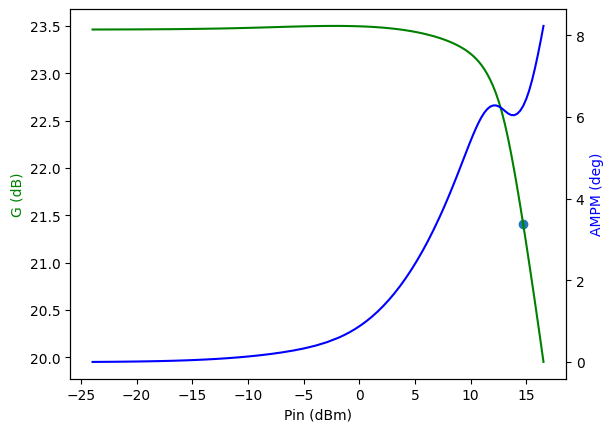

In [30]:
# Getting the index of the smallest GL magnitude
n_match = np.argmin(mc.mag(gl_cpx))

fig, ax1 = plt.subplots()

ax1.plot(Pin_dBm[Pin_dBm.columns[n_match]], G_dB[G_dB.columns[n_match]], 'g-')
ax1.scatter(lookup(Pin_dBm, CompPoints["2dB_maxGain"]).iloc[n_match], lookup(G_dB, CompPoints["2dB_maxGain"]).iloc[n_match])
ax1.set_xlabel('Pin (dBm)')
ax1.set_ylabel('G (dB)', color='g')


ax1b = ax1.twinx()

ax1b.plot(Pin_dBm[Pin_dBm.columns[n_match]], AMPM[AMPM.columns[n_match]], 'b-')
ax1b.set_ylabel('AMPM (deg)', color='b')

plt.show()
#Saving the plot as an image
#plt.savefig("GainAndAMPM.png", dpi = 300)


### Plotting using an interactive widget for data selection

This section demonstrates the application of interactive visualization techniques for enhanced data exploration. Emphasis is placed on:

- **Dual-Aspect Plots:** Visualizations are provided for gain and phase against input power, as well as gain against output power, using a dual-axis approach for a comprehensive view.

- **Smith Chart Integration:** The inclusion of a Smith chart plot highlights key data points, showcasing its application in RF engineering.

- **Interactive Controls:** Sliders are employed to allow real-time manipulation of data points, enabling dynamic interaction with the dataset.

- **Cursor Functionality:** Custom annotations on cursors are used to deliver detailed information on demand, facilitating efficient and user-friendly data exploration.

These methods illustrate how interactive and graphical tools can be effectively utilized to present complex data in an accessible and insightful manner.

In [ ]:
from ipywidgets import interactive, FloatSlider
import ipywidgets as widgets
from matplotlib.widgets import Cursor
import mplcursors

# Enable interactive matplotlib backend for Jupyter
%matplotlib widget

# If this results in display errors use this matplotlib magic instead. Interactive Cursors will not work though...
#%matplotlib inline


# Define the function to update the plot based on the sliders
def update_plot(gl_re, gl_im):
    # Adjusting gl_cpx based on the slider values
    gl_cpx_adjusted = gl_re + 1j * gl_im
    n = np.argmin(np.abs(gl_cpx - gl_cpx_adjusted))

    # Creating a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # First plot for Gain (G_dB) and Phase (AMPM)
    ax1.plot(Pin_dBm[Pin_dBm.columns[n]], G_dB[G_dB.columns[n]], 'g-')
    ax1.set_xlabel('Pin (dBm)')
    ax1.set_ylabel('G (dB)', color='g')
    ax1b = ax1.twinx()
    ax1b.plot(Pin_dBm[Pin_dBm.columns[n]], AMPM[AMPM.columns[n]], 'b-')
    ax1b.set_ylabel('AMPM (deg)', color='b')
    ax1.set_title('Gain and Phase vs. Input Power')  # Adding a title to the first plot
    #Adding interactive cursors
    cursor1 = mplcursors.cursor(ax1, hover=False)
    cursor1.connect("add", lambda sel: sel.annotation.set_text(
        f'Pin: {sel.target[0]:.2f} dBm\nG: {sel.target[1]:.2f} dB'))  # Custom text for cursor on ax1
    cursor1b = mplcursors.cursor(ax1b, hover=False)
    cursor1b.connect("add", lambda sel: sel.annotation.set_text(
        f'Pin: {sel.target[0]:.2f} dBm\nAMPM: {sel.target[1]:.2f} deg'))  # Custom text for cursor on ax1b

    # Second plot for Gain (G_dB) and Efficiency (PAE)
    ax2.plot(Pout_dBm[Pout_dBm.columns[n]], G_dB[G_dB.columns[n]], 'g-')
    ax2.set_xlabel('Pout (dBm)')
    ax2.set_ylabel('G (dB)', color='g')
    ax2b = ax2.twinx()
    ax2b.plot(Pout_dBm[Pout_dBm.columns[n]], PAE[PAE.columns[n]], 'r-')
    ax2b.set_ylabel('PAE (%)', color='r')
    ax2.set_title('Gain and Efficiency vs. Output Power')  # Adding a title to the second plot
    
    #Adding interactive cursors
    cursor2 = mplcursors.cursor(ax2, hover=False)
    cursor2.connect("add", lambda sel: sel.annotation.set_text(
        f'Pout: {sel.target[0]:.2f} dBm\nG: {sel.target[1]:.2f} dB'))  # Custom text for cursor on ax2
    cursor2b = mplcursors.cursor(ax2b, hover=False)
    cursor2b.connect("add", lambda sel: sel.annotation.set_text(
        f'Pout: {sel.target[0]:.2f} dBm\nPAE: {sel.target[1]:.2f} %'))  # Custom text for cursor on ax2b

    # Third plot: Smith Chart
    skrf.plotting.smith(ax=ax3, smithR=1, chart_type="z", draw_labels=False, border=False, ref_imm=1.0, draw_vswr=None)
    ax3.plot(gl_cpx.real, gl_cpx.imag, 'bo')  # Plotting all GL points
    ax3.plot(gl_cpx.real[n], gl_cpx.imag[n], 'ro')  # Highlighting the selected GL point
    ax3.set_title(f"GL_idx: {n}")  # Adding a title to the Smith Chart

    plt.tight_layout()
    plt.show()


# Creating sliders for real and imaginary parts of GL
real_slider = FloatSlider(min=np.min(gl_cpx.real), max=np.max(gl_cpx.real), step=0.1, value=0, description='GL_re')
imag_slider = FloatSlider(min=np.min(gl_cpx.imag), max=np.max(gl_cpx.imag), step=0.1, value=0, description='GL_im')

# Displaying the interactive sliders
interactive(update_plot, gl_re=real_slider, gl_im=imag_slider)

### Creating a Contour Plot
This section outlines how to generate a contour plot from complex datasets using the `plot_contours` function from `MultiADSweep.plotting`. This function is specifically tailored for overlaying contour plots on a Smith chart. It effectively manages irregularly spaced complex coordinates and gracefully handles NaN values. The function offers flexibility, supporting multiple contours, an optional datapoint and mesh overlay, and various customization options.

#### Simple Contour plot

This example illustrates the basic functionality of contour plotting in MultiADSweep.plotting. It focuses on generating a simple contour plot of PAE at peak input power.

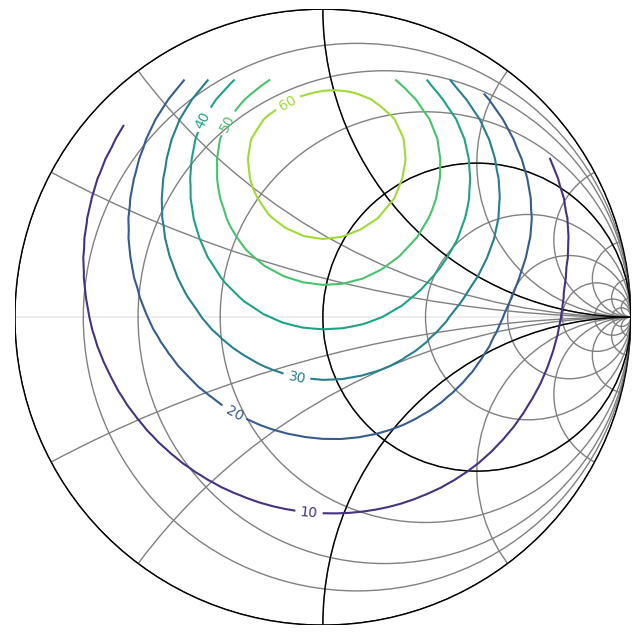

In [34]:
%matplotlib inline
import MultiADSweep.plotting as mp
mp.plot_contours(gl_cpx, PAE.loc[1])
#mp.plot_contours(gl_cpx, PAE.loc[1], show_mesh=True, show_points=True)

plt.show()


#### Finding the Contour Peak

The `find_global_interp_maximum` function, a component of `MultiADSweep.analysis`, is designed to pinpoint the global maximum in a 2D scalar field defined by complex coordinates. It utilizes radial basis function interpolation to precisely determine the point of maximum value.

In [35]:
from MultiADSweep.analysis import find_2d_max_interp

max_pout_point, max_pout = find_2d_max_interp(gl_cpx, Pout_W_comp)
max_pae_point, max_pae = find_2d_max_interp(gl_cpx, PAE_comp)


print(f"Pout_max, max = {max_pout:.2f}W at GL = {mc.ma(max_pout_point)}, Z={mc.ma(mc.stoz(max_pout_point, 50))}" )
print(f"PAE_max = {max_pae:.2f}% at GL = {mc.ma(max_pae_point)}, Z={mc.ma(mc.stoz(max_pae_point, 50))}")

Pout_max, max = 4.98W at GL = 0.386759 ∠ 119.497°, Z=35.436 ∠ 38.3679°
PAE_max = 62.50% at GL = 0.467825 ∠ 93.9584°, Z=47.417 ∠ 50.0754°


#### Plotting multiple contours and adding features manually

Building upon the simple contour plot, this example showcases a more advanced application. Here, we plot multiple contours (PAE and Pout[W]) at 1dB compression and add crosses at the previously identified peak points.

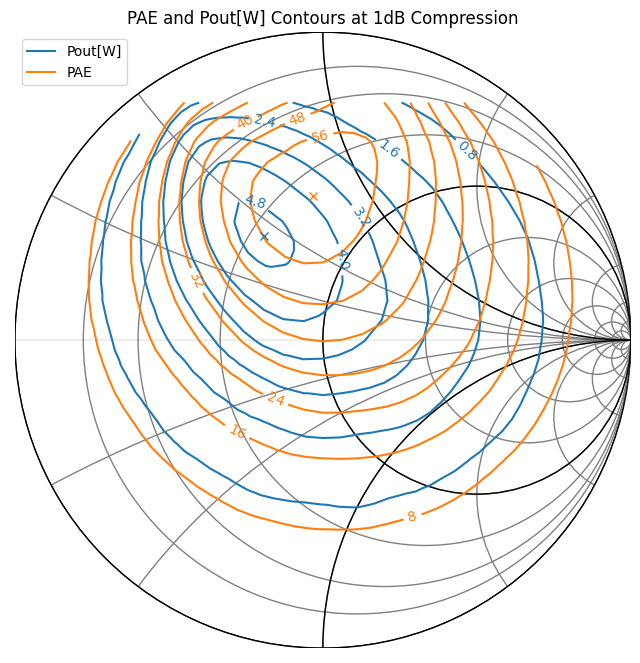

In [36]:
mp.plot_contours(gl_cpx, [Pout_W_comp, PAE_comp], ["Pout[W]","PAE"], show_points=False)
plt.title("PAE and Pout[W] Contours at 1dB Compression")
plt.plot(max_pae_point.real, max_pae_point.imag, "x", color = "tab:orange")
plt.plot(max_pout_point.real, max_pout_point.imag, "x", color = "tab:blue")
plt.show()